# Simple change detection using annual mean NDVI

This example notebook describes how to retrieve data for a small region and epoch of interest, concatenate data from available sensors and calculate the annual mean NDVI values.  You can then select a location of interest based on the change between years, retrieve an NDVI time series for that location and select imagery from before and after the change event

In [1]:
%pylab notebook
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
import rasterio
from datacube.storage.storage import write_dataset_to_netcdf

Populating the interactive namespace from numpy and matplotlib


In [2]:
dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

In [17]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Either as polygon or as lat/lon range
aoi = 'Roper River'
#Define temporal range
start_of_epoch = '1987-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     #'green',
                     'red', 
                     'nir',
                     #'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest, # out sensors that aren't relevant for the time period
sensors = [
    'ls8', #May 2013 to present
    'ls7', #1999 to present
    'ls5' #1986 to present, full contintal coverage from 1987 onwards
        ] 


query = {
    'time': (start_of_epoch, end_of_epoch),
}

#The example shown here is for the Black Saturday Fires in Victoria, but you can update with coordinates for
#your area of interest
lat_max = -14.76
lat_min = -14.8
lon_max = 135.40
lon_min = 135.38  
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [18]:
print query

{'y': (-14.76, -14.8), 'x': (135.38, 135.4), 'crs': 'EPSG:4326', 'time': ('1987-01-01', '2016-12-31')}


## PQ and Index preparation


In [19]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensors[0]+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [20]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [21]:
#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
    #grab the projection info before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    #This line is to make sure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    #Apply the PQ masks to the NBAR
    cloud_free = masking.make_mask(sensor_pq, **mask_components)
    good_data = cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar = sensor_nbar.where(good_data)
    sensor_clean[sensor] = sensor_nbar

In [22]:
sensor_nbar

<xarray.Dataset>
Dimensions:  (time: 668, x: 93, y: 179)
Coordinates:
  * time     (time) datetime64[ns] 1987-05-25 1987-07-21 1987-07-28 ...
  * y        (y) float64 -1.57e+06 -1.57e+06 -1.57e+06 -1.57e+06 -1.57e+06 ...
  * x        (x) float64 3.672e+05 3.673e+05 3.673e+05 3.673e+05 3.673e+05 ...
Data variables:
    red      (time, y, x) float64 1.458e+03 1.415e+03 1.5e+03 1.628e+03 ...
    nir      (time, y, x) float64 2.677e+03 2.677e+03 2.836e+03 2.888e+03 ...

In [23]:
#Concatenate data from different sensors together and sort so that observations are sorted by time rather
# than sensor
nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

In [47]:
nbar_clean

<xarray.Dataset>
Dimensions:  (time: 1461, x: 93, y: 179)
Coordinates:
  * y        (y) float64 -1.57e+06 -1.57e+06 -1.57e+06 -1.57e+06 -1.57e+06 ...
  * x        (x) float64 3.672e+05 3.673e+05 3.673e+05 3.673e+05 3.673e+05 ...
  * time     (time) datetime64[ns] 1987-05-25 1987-07-21 1987-07-28 ...
Data variables:
    nir      (time, y, x) float64 2.677e+03 2.677e+03 2.836e+03 2.888e+03 ...
    red      (time, y, x) float64 1.458e+03 1.415e+03 1.5e+03 1.628e+03 ...
Attributes:
    crs: EPSG:3577
    affine: | 25.00, 0.00, 367225.00|
| 0.00,-25.00,-1570100.00|
| 0.00, 0.00, 1.00|

In [24]:
#Calculate NDVI
ndvi = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))
#ndvi = ((sensor_nbar.nir-sensor_nbar.red)/(sensor_nbar.nir+sensor_nbar.red))

#This controls the colour maps used for plotting NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

#Calculate annual average NDVI values
annual_ndvi = ndvi.groupby('time.year')
annual_mean = annual_ndvi.mean(dim = 'time') #The .mean argument here can be replaced by max, min, median
#but you'll need to update the code below here accordingly
#water_only = all_tss_sorted.where(nbar_clean_sorted['swir1']<1000)
annual_mean_landonly = annual_mean.where(annual_mean>0)

## Plotting an image, view the transect and select a location to retrieve a time series

<IPython.core.display.Javascript object>


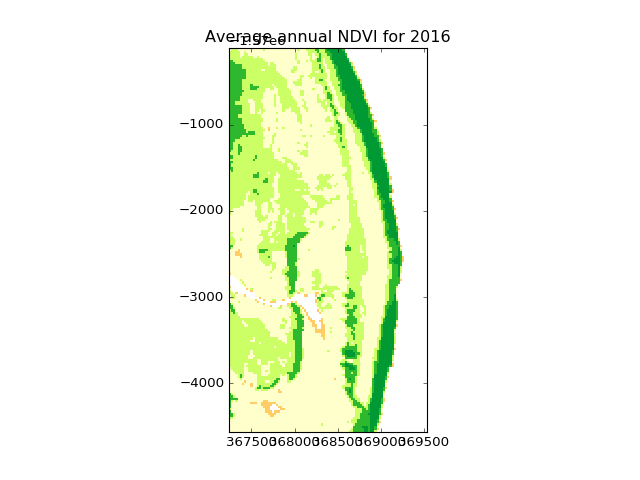

In [41]:
fig = plt.figure()
#Plot the mean NDVI values for a year of interest (yoi)
#Dark green = high amounts of green vegetation through to yellows and oranges being lower amounts of vegetation,
#Blue indicates a NDVI < 0 typically associated with water
yoi = 2016
plt.title('Average annual NDVI for '+str(yoi))
arr_yoi = annual_mean_landonly.sel(year =yoi)
plt.imshow(arr_yoi.squeeze(), interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm,
           extent=[arr_yoi.coords['x'].min(), arr_yoi.coords['x'].max(), 
                   arr_yoi.coords['y'].min(), arr_yoi.coords['y'].max()])

<IPython.core.display.Javascript object>


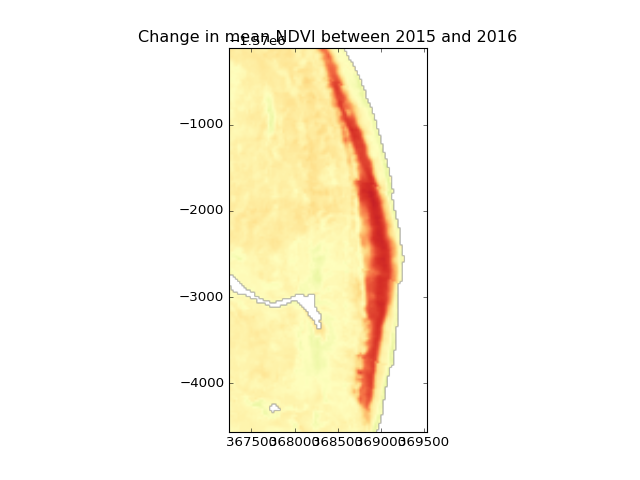

In [48]:
#Calculate the difference between in mean NDVI between two years, a reference year and a change year

fig = plt.figure()
#Define the year you wish to use as a reference point
ref_year = 2015
#Define the year you wish to use to detect change
change_year = 2016
nd_ref_year = annual_mean_landonly.sel(year = (ref_year))
nd_change_year =annual_mean_landonly.sel(year = (change_year))
nd_dif = nd_change_year - nd_ref_year
plt.imshow(nd_dif, cmap = 'RdYlGn', vmin = -0.6, vmax = 0.6, extent=[nd_dif.coords['x'].min(), nd_dif.coords['x'].max(), 
                   nd_dif.coords['y'].min(), nd_dif.coords['y'].max()])
#nd_dif.plot(cmap = 'RdYlGn', vmin = -0.3, vmax = 0.3)
#Click on this image to chose the location for time series extraction
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig.canvas.mpl_connect('button_press_event', callback)
plt.title('Change in mean NDVI between '+str(ref_year)+' and '+str(change_year))
plt.show()
display(w)

## This section is for viewing a time series of NDVI - and retrieving the image that corresponds with a particular point on a time series

In [49]:
#this converts the map x coordinate into image x coordinates
image_coords = ~affine * (x, y)
imagex = int(image_coords[0])
imagey = int(image_coords[1])

#retrieve the time series for the pixel location clicked above
ts_ndvi = ndvi.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any')

<IPython.core.display.Javascript object>


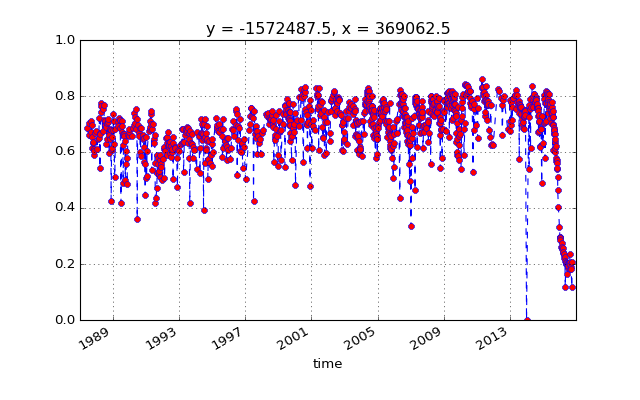

['1987-01-01', '2016-12-31', 0, 1]

In [50]:
#Use this plot to visualise a time series and select the image that corresponds with a point in the time series
def callback(event):
    global time_int, devent
    devent = event
    time_int = event.xdata
    #time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

fig = plt.figure(figsize=(8,5))
fig.canvas.mpl_connect('button_press_event', callback)
plt.show()
display(w)

firstyear = '1987-01-01'
lastyear = '2016-12-31'
ts_ndvi.plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='r')
plt.grid()

plt.axis([firstyear , lastyear ,0, 1])

In [ ]:
#Convert the point clicked in the time series to a date and retrieve the corresponding image
time_slice = matplotlib.dates.num2date(time_int).date()
rgb = nbar_clean.sel(time =time_slice, method = 'nearest').to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 3000
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

In [ ]:
#This image shows the time slice of choice and the location of the time series 
fig = plt.figure(figsize =(12,6))
#plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r')
plt.scatter(x = [x], y = [y], c= 'yellow', marker = 'D')
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()]
          )
plt.title(time_slice)
plt.show()

In [31]:
#Convert the data array into a dataset so that netCDF has the necessary variable names
nd_dif_ds = nd_dif.to_dataset(name = 'ndvi_delta')
# add the coordinate reference system (crs) back into the attributes
nd_dif_ds.attrs['crs'] = crs

In [33]:
write_dataset_to_netcdf(nd_dif_ds, '/g/data/r78/lxl554/ndvi_mean_delta_for'+aoi+'_from_'+str(change_year)+'to'+str(ref_year)+'.nc')